In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import os


from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

In [2]:
# set up folder with data

os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\Download_and_Prepare_Data')

In [3]:
# read data

TexasDemandData_Raw = pd.read_csv('Electricity_Demand_Texas_data.csv',\
                              parse_dates =['Date'],
                              index_col = 'Date')

In [4]:
# rename and sort

TexasDemandData = TexasDemandData_Raw\
                        .rename(columns = {'value':'Demand'})\
                        .sort_index()

In [5]:
# Show data
print(TexasDemandData)

                           Demand
Date                             
2015-07-01 06:00:00+00:00   37456
2015-07-01 07:00:00+00:00   35119
2015-07-01 08:00:00+00:00   33638
2015-07-01 09:00:00+00:00   32798
2015-07-01 10:00:00+00:00   32805
...                           ...
2022-12-03 18:00:00+00:00   43311
2022-12-03 19:00:00+00:00   43003
2022-12-03 20:00:00+00:00   42628
2022-12-03 21:00:00+00:00   42454
2022-12-03 22:00:00+00:00   42453

[65057 rows x 1 columns]


In [6]:
# remove a index time zone info and take first and last observation
TexasDemandData = TexasDemandData.tz_localize(None)

FirstDemandObserwation = TexasDemandData.index[0]
LastDemandObserwation = TexasDemandData.index[-1]

In [7]:
# Fill data frequency and check NA for Demand Data

TexasDemandData = TexasDemandData.asfreq('H')

print( TexasDemandData.isna().sum() )

Demand    48
dtype: int64


In [8]:
# Take indexes with NA

TexasDemandData_NA = TexasDemandData[TexasDemandData.isna().any(axis=1)]
IndexNA = TexasDemandData_NA.index

print(IndexNA)

DatetimeIndex(['2018-07-01 06:00:00', '2018-07-01 07:00:00',
               '2018-07-01 08:00:00', '2018-07-01 09:00:00',
               '2018-07-01 10:00:00', '2018-07-01 11:00:00',
               '2018-07-01 12:00:00', '2018-07-01 13:00:00',
               '2018-07-01 14:00:00', '2018-07-01 15:00:00',
               '2018-07-01 16:00:00', '2018-07-01 17:00:00',
               '2018-07-01 18:00:00', '2018-07-01 19:00:00',
               '2018-07-01 20:00:00', '2018-07-01 21:00:00',
               '2018-07-01 22:00:00', '2018-07-01 23:00:00',
               '2018-07-02 00:00:00', '2018-07-02 01:00:00',
               '2018-07-02 02:00:00', '2018-07-02 03:00:00',
               '2018-07-02 04:00:00', '2018-07-02 05:00:00',
               '2018-11-11 07:00:00', '2018-11-11 08:00:00',
               '2018-11-11 09:00:00', '2018-11-11 10:00:00',
               '2018-11-11 11:00:00', '2018-11-11 12:00:00',
               '2018-11-11 13:00:00', '2018-11-11 14:00:00',
               '2018-11-

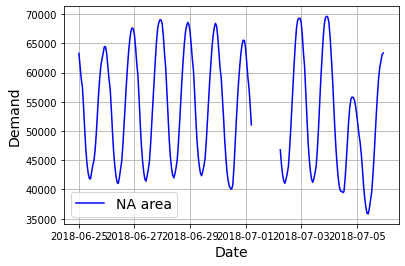

In [9]:
Start_period = '2018-06-25'
End_period = '2018-07-05'

plt.plot(TexasDemandData.loc[Start_period:End_period], c='blue', alpha=1.0,  label='NA area')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

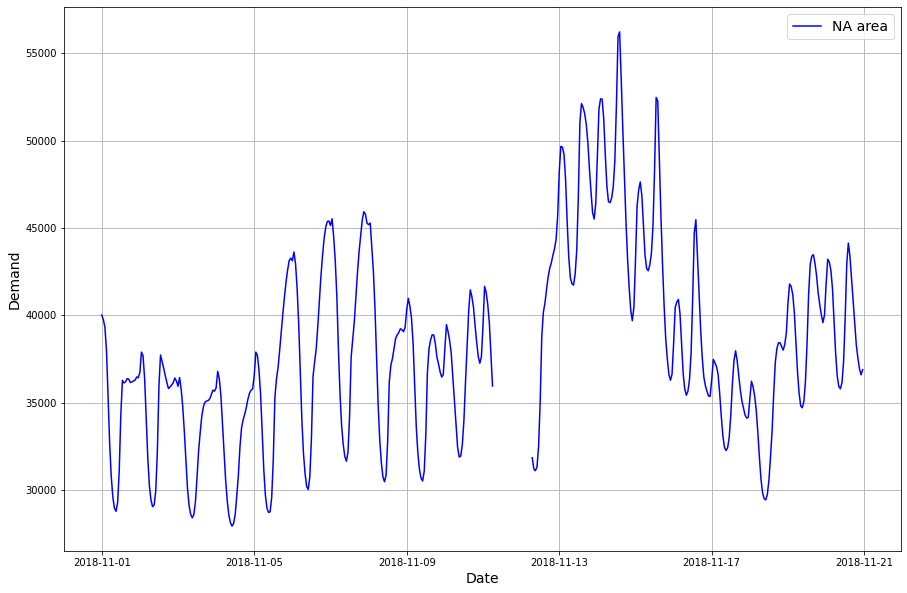

In [10]:
Start_period = '2018-11-01'
End_period = '2018-11-20'

plt.plot(TexasDemandData.loc[Start_period:End_period], c='blue', alpha=1.0,  label='NA area')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [11]:
# Fill NA in Demand data

In [12]:
# Function for creating pipeline
def get_simple_ridge_pipeline():
    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': 168}

    node_final = SecondaryNode('ridge', nodes_from=[node_lagged])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_simple_ridge_pipeline()
model_gapfiller = ModelGapFiller(gap_value=-100.0,
                                 pipeline=pipeline)


# Filling in the gaps

array_with_gaps  = np.array(TexasDemandData.replace(np.nan, -100)['Demand'])
TexasDemandData_Filled = model_gapfiller.forward_inverse_filling(array_with_gaps)
TexasDemandData['filled'] = TexasDemandData_Filled

In [13]:
Fillled_Only = pd.DataFrame( data = TexasDemandData_Filled, index = TexasDemandData.index, columns = ['Filled'] )\
                    .loc[IndexNA]



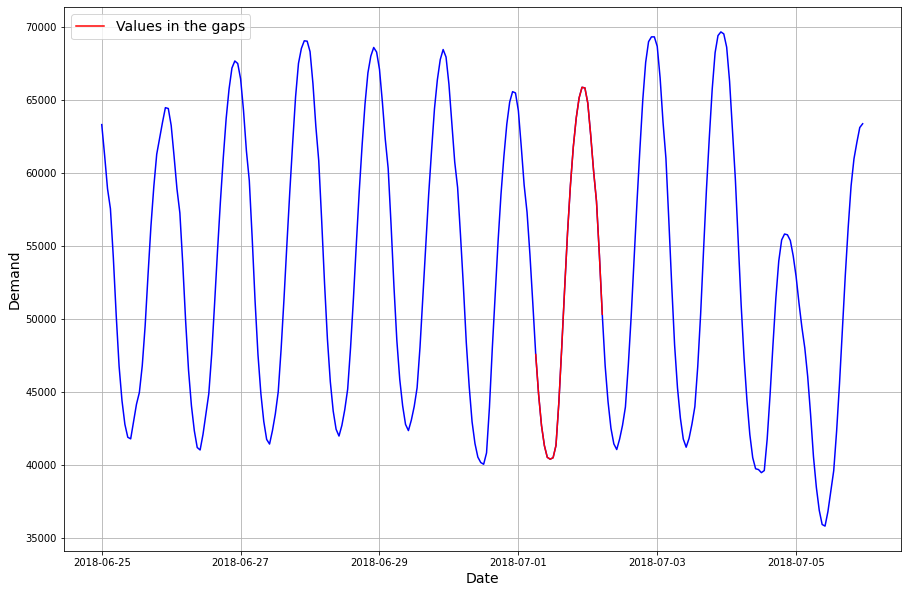

In [14]:
# Plot first filled gap

Start_period = '2018-06-25'
End_period = '2018-07-05'

plt.plot(TexasDemandData['filled'].loc[Start_period:End_period], c='blue', alpha=1.0)
plt.plot(Fillled_Only.loc[Start_period:End_period], c='red', alpha=1.0, label='Values in the gaps')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

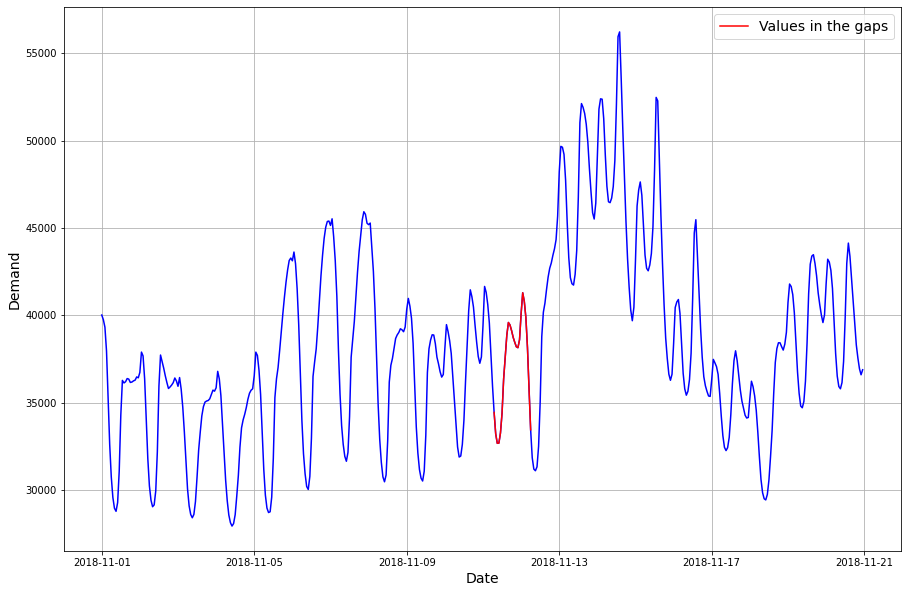

In [15]:
# Plot second filled gap

Start_period = '2018-11-01'
End_period = '2018-11-20'

plt.plot(TexasDemandData['filled'].loc[Start_period:End_period], c='blue', alpha=1.0)
plt.plot(Fillled_Only.loc[Start_period:End_period], c='red', alpha=1.0, label='Values in the gaps')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [ ]:
############################################################################
############################################################################
#%% Whether data
############################################################################
############################################################################

In [16]:
# read data
AustinWheatherData_raw = pd.read_csv('Austin_wheather_data_OpenMeteo.csv',\
                                     parse_dates =['dateTime'])

# show columns
print(AustinWheatherData_raw.columns)

Index(['dateTime', 'air_temperature', 'humidity', 'apparent_temperature',
       'sky_cover', 'shortwave_radiation', 'wind_speed', 'wind_direction'],
      dtype='object')


In [17]:
# rename, set index and select columns

AustinWheatherData = AustinWheatherData_raw.copy()\
                            .rename(columns = {'dateTime':'Date'})\
                            .set_index('Date')\
                            [['air_temperature', 'humidity', 'sky_cover', 'wind_speed']]
            
AustinWheatherData = AustinWheatherData.loc[FirstDemandObserwation:]

In [18]:
# check NA

AustinWheatherData.isna().sum()

air_temperature    0
humidity           0
sky_cover          0
wind_speed         0
dtype: int64